In [1]:
# Let's make this notebook compatible for Python 2 and 3
from __future__ import division, print_function

# Import libraries
import pandas as pd
import numpy as np
import os
import math
import itertools

# for visualization
import matplotlib.pyplot as plt

# to import module from parent directory
import sys
sys.path.append('..')

# Dataset API from sklearn
from sklearn import datasets

In [2]:
from utils import normalize, euclidean_distance, calculate_covariance_matrix, Plot

In [3]:
class GaussianMixtureModel():
    """A probabilistic clustering method for determining groupings among data samples.

    Parameters:
    -----------
    k: int
        The number of clusters the algorithm will form.
    max_iterations: int
        The number of iterations the algorithm will run for if it does
        not converge before that. 
    tolerance: float
        If the difference of the results from one iteration to the next is
        smaller than this value we will say that the algorithm has converged.
    """
    def __init__(self, k=2, max_iterations=2000, tolerance=1e-8):
        self.k = k
        self.parameters = []
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.responsibilities = []
        self.sample_assignments = None
        self.responsibility = None

    def _init_random_gaussians(self, X):
        """ Initialize gaussian randomly """
        n_samples = np.shape(X)[0]
        self.priors = (1 / self.k) * np.ones(self.k)
        for i in range(self.k):
            params = {}
            params["mean"] = X[np.random.choice(range(n_samples))]
            params["cov"] = calculate_covariance_matrix(X)
            self.parameters.append(params)

    def multivariate_gaussian(self, X, params):
        """ Likelihood """
        n_features = np.shape(X)[1]
        mean = params["mean"]
        covar = params["cov"]
        determinant = np.linalg.det(covar)
        likelihoods = np.zeros(np.shape(X)[0])
        for i, sample in enumerate(X):
            d = n_features  # dimension
            coeff = (1.0 / (math.pow((2.0 * math.pi), d / 2)
                            * math.sqrt(determinant)))
            exponent = math.exp(-0.5 * (sample - mean).T.dot(np.linalg.pinv(covar)).dot((sample - mean)))
            likelihoods[i] = coeff * exponent

        return likelihoods

    def _get_likelihoods(self, X):
        """ Calculate the likelihood over all samples """
        n_samples = np.shape(X)[0]
        likelihoods = np.zeros((n_samples, self.k))
        for i in range(self.k):
            likelihoods[
                :, i] = self.multivariate_gaussian(
                X, self.parameters[i])
        return likelihoods

    def _expectation(self, X):
        """ Calculate the responsibility """
        # Calculate probabilities of X belonging to the different clusters
        weighted_likelihoods = self._get_likelihoods(X) * self.priors
        sum_likelihoods = np.expand_dims(
            np.sum(weighted_likelihoods, axis=1), axis=1)
        # Determine responsibility as P(X|y)*P(y)/P(X)
        self.responsibility = weighted_likelihoods / sum_likelihoods
        # Assign samples to cluster that has largest probability
        self.sample_assignments = self.responsibility.argmax(axis=1)
        # Save value for convergence check
        self.responsibilities.append(np.max(self.responsibility, axis=1))

    def _maximization(self, X):
        """ Update the parameters and priors """
        # Iterate through clusters and recalculate mean and covariance
        for i in range(self.k):
            resp = np.expand_dims(self.responsibility[:, i], axis=1)
            mean = (resp * X).sum(axis=0) / resp.sum()
            covariance = (X - mean).T.dot((X - mean) * resp) / resp.sum()
            self.parameters[i]["mean"], self.parameters[
                i]["cov"] = mean, covariance

        # Update weights
        n_samples = np.shape(X)[0]
        self.priors = self.responsibility.sum(axis=0) / n_samples

    def _converged(self, X):
        """ Covergence if || likehood - last_likelihood || < tolerance """
        if len(self.responsibilities) < 2:
            return False
        diff = np.linalg.norm(
            self.responsibilities[-1] - self.responsibilities[-2])
        # print ("Likelihood update: %s (tol: %s)" % (diff, self.tolerance))
        return diff <= self.tolerance

    def predict(self, X):
        """ Run GMM and return the cluster indices """
        # Initialize the gaussians randomly
        self._init_random_gaussians(X)

        # Run EM until convergence or for max iterations
        for _ in range(self.max_iterations):
            self._expectation(X)    # E-step
            self._maximization(X)   # M-step

            # Check convergence
            if self._converged(X):
                break

        # Make new assignments and return them
        self._expectation(X)
        return self.sample_assignments


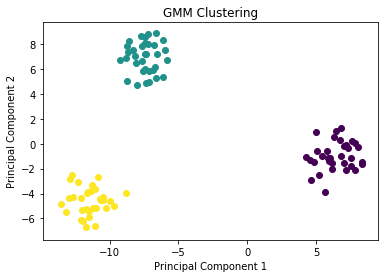

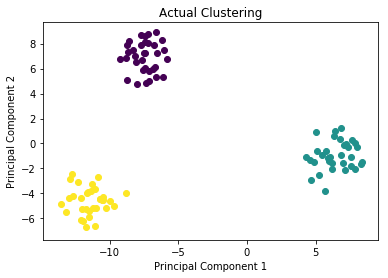

In [4]:
def main():
    # Load the dataset
    X, y = datasets.make_blobs()

    # Cluster the data
    clf = GaussianMixtureModel(k=3)
    y_pred = clf.predict(X)

    p = Plot()
    p.plot_in_2d(X, y_pred, title="GMM Clustering")
    p.plot_in_2d(X, y, title="Actual Clustering")


if __name__ == "__main__":
    main()